# Classification

In [14]:
from pretraitement import TextPreTraitement
from clean import clean_claimKG
from classification import trueVSfalse, trueFalseVSmixture, trueVSfalseVSmixture, cut_data
from utilities import plot_confusion_matrix

In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# classifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [16]:
file_name = "../data/claimKG.csv"
origin = pd.read_csv(file_name)

origin = clean_claimKG(origin, verbose=False, inplace=True)

## Découpage des données

Ici nous générons trois groupes de données

- `kg_tf` contient les deux classes **True** -> `1` et **False** -> `0`.
- `kg_tf_m` contient les deux classes **True-False** -> `0` et **Mixture** -> `1`.
- `kg_tfm` contient les trois classes **True** -> `1`, **False** -> `0` et **Mixture** -> `2`

<AxesSubplot:title={'center':'Distibution des données True VS False'}>

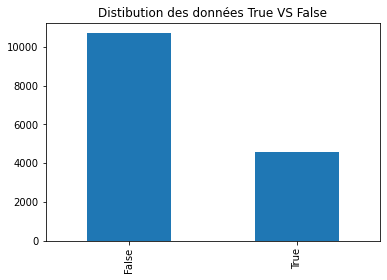

In [17]:
kg_tf = trueVSfalse(origin)
kg_tf_m = trueFalseVSmixture(origin)
kg_tfm = trueVSfalseVSmixture(origin)

index_tf={0:'False', 1: 'True'}
index_tf_m={0:'TrueFalse', 1: 'Mixture'}
index_tfm={0:'False', 1: 'True', 2: 'Mixture'}

kg_tf['ratingValue'].value_counts().rename(index=index_tf).plot(
    kind='bar',title="Distibution des données True VS False")

Comme afficher dans la cellule précedente, le nombre d'assertions pour chaque classe est mal balancé. Ce qui peut conduire à un mauvais apprentissage de la part des modèles. En effet, par exemple, dans la tâche **True** VS **False**, il y a 70% d'assertions **False**. le modèle va donc être biaisé et être moins performant pour la prédiction des assertions **False**.

On a donc mis en point une fonction de sous-échantillonnage (Downsampling) pour remédier à ce problème.

AxesSubplot(0.125,0.125;0.775x0.755)


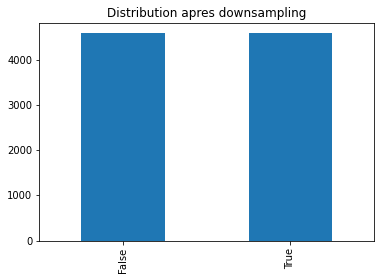

In [18]:
kg = kg_tf
index = index_tf

downsampling = True
if downsampling:
    kg = cut_data(kg)
    print(kg['ratingValue'].value_counts().rename(index=index).plot(
        kind='bar',title="Distribution apres downsampling"))

## Classification

### Jeu d'apprentissage et de test

Dans cette étape nous procédant à la création d'un jeu d'apprentissage et de test en utilsant la fonction `train_test_split` de la librairie `sklearn`.

Nous avons choisis de reserver 70% des données pour l'apprentissage et les 30% restantes pour l'étape de validation.

In [19]:
X=kg['claimReview_claimReviewed'] # Les assertions
y=kg['ratingValue'] # les labels

train_size=0.7

X_train,X_test,y_train,y_test=train_test_split(X, y, 
                                               train_size=train_size ,
                                               random_state=30,stratify=y)

Dans ce qui suit, nous utiliserons la classe `TextPreTraitement` vue précédemment (Notebook [pretraitement](pretraitement.ipynb)) pour le prétraitement des données.

In [20]:
pretraitement = TextPreTraitement(stopword=True, 
                                  lem=True, 
                                  lowercase=True, 
                                  number2words=True)

X_train = pretraitement.fit_transform(X_train)

X_test = pretraitement.fit_transform(X_test)

### Vectorisation

L'objectif ici est de transformer l'ensemble des assertions (composées de mots) en un ensemble de vecteurs pour que les modèles puissent effectuer des opérations mathématique dessus. Il existe trois approches principales :

- [Bag of Word](https://fr.wikipedia.org/wiki/Sac_de_mots)
- [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF)
- [Word2Vec](https://fr.wikipedia.org/wiki/Word2vec)

Nous utiliserons principalement TF-IDF pour la vectorisation des données.

In [21]:
ngram=(1,2)

vectorizer = TfidfVectorizer(
            lowercase=False,
            ngram_range=ngram,
            preprocessor=lambda x:x,
            min_df=0.005, 
            max_df=0.7)

In [22]:
vectorizer.fit(X_train)
vectorizer.fit(X_test)

vector_train = pd.DataFrame(
        data=vectorizer.transform(X_train).toarray(),
        columns=vectorizer.get_feature_names()
    )
vector_test = pd.DataFrame(
        data=vectorizer.transform(X_test).toarray(),
        columns=vectorizer.get_feature_names()
    )

In [23]:
display(vector_train.sample(5))
display(vector_test.sample(5))

,000,abortion,accident,account,across,act,actor,actually,address,administration,...,word,work,worker,world,would,write,year,year old,york,young
3552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.264927,0.0,0.0,0.0,0.0,0.0


,000,abortion,accident,account,across,act,actor,actually,address,administration,...,word,work,worker,world,would,write,year,year old,york,young
547,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1605,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
427,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1639,0.0,0.0,0.0,0.0,0.0,0.297684,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Classifieur

Comme l'indique le [*No free lunch theorem*](https://en.wikipedia.org/wiki/No_free_lunch_theorem), il n'existe pas de classifieur universel. Il est donc toujours nécessaire d'en évaluer plusieurs afin de trouver le plus pertinent pour notre situation.

Les algorithmes testés sont les suivants:

- [SVM](https://fr.wikipedia.org/wiki/Machine_%C3%A0_vecteurs_de_support)
- [Naive Bayes](https://fr.wikipedia.org/wiki/Classification_na%C3%AFve_bay%C3%A9sienne)
- [Decision Tree](https://fr.wikipedia.org/wiki/Arbre_de_d%C3%A9cision_(apprentissage))
- [K-nearest neighbors](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins)
- [Logistic Regression](https://fr.wikipedia.org/wiki/R%C3%A9gression_logistique)

In [ ]:
models = dict()
param = dict()

models['svm'] = SVC()
param['svm'] = [{'C': [0.01, 0.1], 
    'gamma' : ['auto', 0.1, 1], 
    'kernel': ['linear','rbf']}]

models['nb'] = GaussianNB()
param['nb'] = []

models['dt'] = DecisionTreeClassifier()
param['dt'] = [{'max_depth': [5,10,15]},
    {'criterion': ['gini', 'entropy']},
    {'min_samples_leaf': [5,6,7]}]

models['knn'] = KNN()
param['knn'] = [{'n_neighbors': list(range(5,10))},
    {'metric': ['euclidean','manhattan']}]

models['lr'] = LogisticRegression()
param['lr'] = [{'solver': ['newton-cg', 'ibfgs', 'liblinear', 'sag', 'saga']}]

predictions = []

for name, model in models.items():
    print("Searching best param for "+name)
    gd_sr = GridSearchCV(estimator=model,  
                     param_grid=param[name],
                     scoring='accuracy',
                     cv=5,
                     n_jobs=1)
    
    print("Best score: "+gd_sr.best_score_)
    gd_sr.fit(vector_train, y_train)
    predictions.append((key,gd_sr.best_score_,gd_sr.best_estimator_))

Searching best param for svm


In [ ]:
for name, acc, param in predictions:
    print("%s - score:%0.3f, param: %s"% (name, acc, param))